In [1]:
import numpy as np
import torch
import torchvision
from torch import nn, optim
from torch.nn import functional as F
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

In [2]:
batch_size_train = 100
batch_size_test = 100
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR100('cifar100', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.CIFAR100('cifar100', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

100%|██████████| 169001437/169001437 [00:03<00:00, 49001137.80it/s]


Extracting cifar100/cifar-100-python.tar.gz to cifar100
Files already downloaded and verified


In [5]:
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.fc0 = nn.Linear(3072,1024)
        self.fc1 = nn.Linear(1024, 100)

    def forward(self, x):
        x = x.view((-1,3072))
        x = F.relu(self.fc0(x))
        return self.fc1(x)

In [6]:

model = mlp().cuda()
test_loss_min = np.Inf
LR=5e-4
optimizer = optim.Adam(model.parameters(), lr=LR)
test_acc_max = -100
history = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 25):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(model.parameters(), lr=LR)

    model.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    model.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = model(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min, test_loss))
        torch.save(model.state_dict(), 'CIFAR100_Normal_MLP_leastLoss.pt')
        test_loss_min = test_loss
    if test_acc >= test_acc_max:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max, test_acc))
        torch.save(model.state_dict(), 'CIFAR100_Normal_MLP_Most_Accuracy.pt')
        test_acc_max = test_acc
    history['train_loss'].append(train_loss)
    history['valid_loss'].append(test_loss)
    history['train_acc'].append(train_acc)
    history['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 3.916894 - Testing Loss: 3.696311 - Training Accuracy: 11.12% - Testing Accuracy: 14.82%
Testing loss decreased (inf --> 3.696311). The new model saved.
Testing Acc increased (-100.000000 --> 14.820000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 3.533402 - Testing Loss: 3.524091 - Training Accuracy: 17.49% - Testing Accuracy: 18.74%
Testing loss decreased (3.696311 --> 3.524091). The new model saved.
Testing Acc increased (14.820000 --> 18.740000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 3.362446 - Testing Loss: 3.443707 - Training Accuracy: 20.28% - Testing Accuracy: 19.89%
Testing loss decreased (3.524091 --> 3.443707). The new model saved.
Testing Acc increased (18.740000 --> 19.890000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 3.235835 - Testing Loss: 3.391568 - Training Accuracy: 22.83% - Testing Accuracy: 20.64%
Testing loss decreased (3.443707 --> 3.391568). The new model saved.
Testing Acc increased (19.890000 --> 20.640000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 3.132397 - Testing Loss: 3.353318 - Training Accuracy: 24.94% - Testing Accuracy: 21.97%
Testing loss decreased (3.391568 --> 3.353318). The new model saved.
Testing Acc increased (20.640000 --> 21.970000). The new model saved.
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 3.023543 - Testing Loss: 3.362203 - Training Accuracy: 26.91% - Testing Accuracy: 22.76%
Testing Acc increased (21.970000 --> 22.760000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 2.934504 - Testing Loss: 3.414464 - Training Accuracy: 28.71% - Testing Accuracy: 22.58%
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 2.851655 - Testing Loss: 3.403867 - Training Accuracy: 30.55% - Testing Accuracy: 23.18%
Testing Acc increased (22.760000 --> 23.180000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 2.780954 - Testing Loss: 3.433321 - Training Accuracy: 31.86% - Testing Accuracy: 23.11%
Epoch 10 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 2.698392 - Testing Loss: 3.480369 - Training Accuracy: 33.50% - Testing Accuracy: 23.42%
Testing Acc increased (23.180000 --> 23.420000). The new model saved.
Epoch 11 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 2.611978 - Testing Loss: 3.534271 - Training Accuracy: 35.56% - Testing Accuracy: 23.16%
Epoch 12 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 2.551072 - Testing Loss: 3.547780 - Training Accuracy: 36.90% - Testing Accuracy: 24.17%
Testing Acc increased (23.420000 --> 24.170000). The new model saved.
Epoch 13 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 2.478893 - Testing Loss: 3.606229 - Training Accuracy: 38.06% - Testing Accuracy: 23.54%
Epoch 14 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 2.413971 - Testing Loss: 3.699113 - Training Accuracy: 39.62% - Testing Accuracy: 23.69%
Epoch 15 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 2.347294 - Testing Loss: 3.756812 - Training Accuracy: 41.27% - Testing Accuracy: 23.77%
Epoch 16 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 2.281841 - Testing Loss: 3.783238 - Training Accuracy: 42.75% - Testing Accuracy: 23.79%
Epoch 17 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 2.217363 - Testing Loss: 3.924070 - Training Accuracy: 44.36% - Testing Accuracy: 23.68%
Epoch 18 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 2.166630 - Testing Loss: 3.888048 - Training Accuracy: 45.34% - Testing Accuracy: 24.47%
Testing Acc increased (24.170000 --> 24.470000). The new model saved.
Epoch 19 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 2.116963 - Testing Loss: 4.010255 - Training Accuracy: 46.53% - Testing Accuracy: 24.19%
Epoch 20 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 2.061664 - Testing Loss: 4.058128 - Training Accuracy: 47.87% - Testing Accuracy: 24.36%
Epoch 21 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 1.995552 - Testing Loss: 4.151313 - Training Accuracy: 49.42% - Testing Accuracy: 23.97%
Epoch 22 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 1.952376 - Testing Loss: 4.166289 - Training Accuracy: 50.20% - Testing Accuracy: 24.51%
Testing Acc increased (24.470000 --> 24.510000). The new model saved.
Epoch 23 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 1.910978 - Testing Loss: 4.279073 - Training Accuracy: 51.21% - Testing Accuracy: 24.03%
Epoch 24 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 1.868247 - Testing Loss: 4.303152 - Training Accuracy: 52.25% - Testing Accuracy: 24.23%


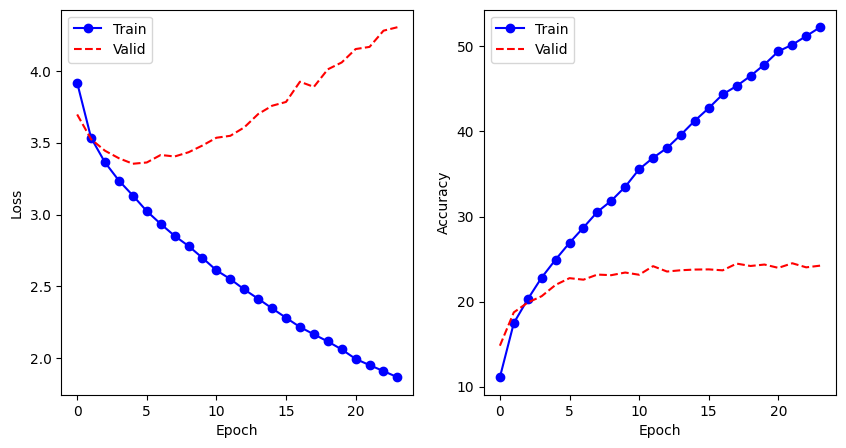

In [7]:
import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], 'bo-', label='Train')
plt.plot(history['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], 'bo-', label='Train')
plt.plot(history['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [8]:
modelSynScaL = mlp().cuda()
test_loss_min_SynScaL = np.Inf
LR=5e-4
optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)
test_acc_max_SynScaL = -100
historySynScaL = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 25):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaL.parameters(), lr=LR)

    modelSynScaL.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target)+ 1.0 * (0.01 - output.mean())**2
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()

    #validate
    modelSynScaL.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaL(data)

        loss = F.cross_entropy(output, target) +  1.0 * (0.01 - output.mean())**2
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaL:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaL, test_loss))
        torch.save(modelSynScaL.state_dict(), 'CIFAR100_SynScaL_MLP_leastLoss.pt')
        test_loss_min_SynScaL = test_loss
    if test_acc >= test_acc_max_SynScaL:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaL, test_acc))
        torch.save(modelSynScaL.state_dict(), 'CIFAR100_SynScaL_MLP_Most_Accuracy.pt')
        test_acc_max_SynScaL = test_acc
    historySynScaL['train_loss'].append(train_loss)
    historySynScaL['valid_loss'].append(test_loss)
    historySynScaL['train_acc'].append(train_acc)
    historySynScaL['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 3.941434 - Testing Loss: 3.719220 - Training Accuracy: 11.03% - Testing Accuracy: 14.61%
Testing loss decreased (inf --> 3.719220). The new model saved.
Testing Acc increased (-100.000000 --> 14.610000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 3.556179 - Testing Loss: 3.543791 - Training Accuracy: 17.17% - Testing Accuracy: 17.86%
Testing loss decreased (3.719220 --> 3.543791). The new model saved.
Testing Acc increased (14.610000 --> 17.860000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 3.391868 - Testing Loss: 3.444963 - Training Accuracy: 20.03% - Testing Accuracy: 19.94%
Testing loss decreased (3.543791 --> 3.444963). The new model saved.
Testing Acc increased (17.860000 --> 19.940000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 3.263709 - Testing Loss: 3.441982 - Training Accuracy: 22.24% - Testing Accuracy: 20.23%
Testing loss decreased (3.444963 --> 3.441982). The new model saved.
Testing Acc increased (19.940000 --> 20.230000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 3.154183 - Testing Loss: 3.374886 - Training Accuracy: 24.92% - Testing Accuracy: 21.63%
Testing loss decreased (3.441982 --> 3.374886). The new model saved.
Testing Acc increased (20.230000 --> 21.630000). The new model saved.
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 3.047346 - Testing Loss: 3.370533 - Training Accuracy: 26.66% - Testing Accuracy: 22.42%
Testing loss decreased (3.374886 --> 3.370533). The new model saved.
Testing Acc increased (21.630000 --> 22.420000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 2.958483 - Testing Loss: 3.374107 - Training Accuracy: 28.41% - Testing Accuracy: 22.84%
Testing Acc increased (22.420000 --> 22.840000). The new model saved.
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 2.875651 - Testing Loss: 3.357331 - Training Accuracy: 30.31% - Testing Accuracy: 23.49%
Testing loss decreased (3.370533 --> 3.357331). The new model saved.
Testing Acc increased (22.840000 --> 23.490000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 2.791575 - Testing Loss: 3.401597 - Training Accuracy: 31.91% - Testing Accuracy: 23.45%
Epoch 10 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 2.702968 - Testing Loss: 3.393651 - Training Accuracy: 34.17% - Testing Accuracy: 23.35%
Epoch 11 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 2.612293 - Testing Loss: 3.433613 - Training Accuracy: 35.91% - Testing Accuracy: 23.74%
Testing Acc increased (23.490000 --> 23.740000). The new model saved.
Epoch 12 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 2.538703 - Testing Loss: 3.482904 - Training Accuracy: 37.36% - Testing Accuracy: 23.18%
Epoch 13 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 2.463163 - Testing Loss: 3.493594 - Training Accuracy: 39.08% - Testing Accuracy: 23.31%
Epoch 14 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 2.396320 - Testing Loss: 3.539579 - Training Accuracy: 40.57% - Testing Accuracy: 23.34%
Epoch 15 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 2.316401 - Testing Loss: 3.560587 - Training Accuracy: 42.49% - Testing Accuracy: 24.11%
Testing Acc increased (23.740000 --> 24.110000). The new model saved.
Epoch 16 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 2.233345 - Testing Loss: 3.611891 - Training Accuracy: 44.46% - Testing Accuracy: 24.10%
Epoch 17 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 2.166833 - Testing Loss: 3.638129 - Training Accuracy: 45.57% - Testing Accuracy: 24.62%
Testing Acc increased (24.110000 --> 24.620000). The new model saved.
Epoch 18 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 2.107383 - Testing Loss: 3.725798 - Training Accuracy: 47.19% - Testing Accuracy: 23.70%
Epoch 19 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 2.046778 - Testing Loss: 3.743667 - Training Accuracy: 48.34% - Testing Accuracy: 24.14%
Epoch 20 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 1.980482 - Testing Loss: 3.830736 - Training Accuracy: 50.15% - Testing Accuracy: 24.12%
Epoch 21 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 1.908500 - Testing Loss: 3.938248 - Training Accuracy: 51.93% - Testing Accuracy: 23.13%
Epoch 22 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 1.850353 - Testing Loss: 3.985708 - Training Accuracy: 53.28% - Testing Accuracy: 23.87%
Epoch 23 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 1.794475 - Testing Loss: 4.015286 - Training Accuracy: 54.52% - Testing Accuracy: 24.15%
Epoch 24 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 1.743948 - Testing Loss: 4.112008 - Training Accuracy: 55.82% - Testing Accuracy: 24.20%


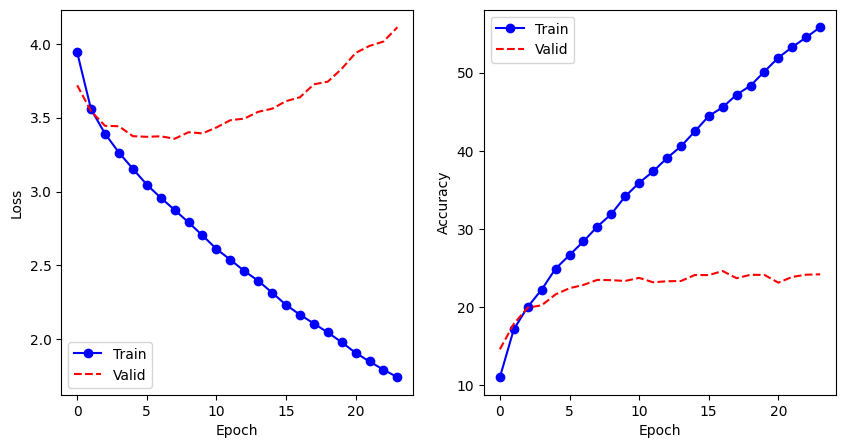

In [9]:
fig=plt.figure(1,figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(historySynScaL['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaL['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaL['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [10]:
def update_param(parameter_data, activation, gamma=0.1,mean = 0.1):
    activation = activation.data.numpy().mean(axis=(0)).squeeze()[:,None]
    param = parameter_data.numpy()
    new_param = param+gamma*np.clip((param*param)*(mean - activation).mean(),-1,1)
    return torch.from_numpy(new_param)
def perform_update(m):
    if type(m) == nn.Linear:
        m.eval()
        im = np.random.uniform(-1, 1, (100, m.in_features))+0.1
        im_as_ten = torch.from_numpy(im).float().cuda()
        x = Variable(im_as_ten, requires_grad=True)
        x = F.relu(m(x))
        m.weight.data = update_param(m.weight.data.cpu(),activation=x.cpu()).cuda()

In [12]:

modelSynScaW = mlp().cuda()
test_loss_min_SynScaW= np.Inf
test_acc_max_SynScaW = -100
LR=5e-4
optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)
historySynScaW = {'train_loss': [], 'valid_loss': [], 'train_acc': [], 'valid_acc': []}
for epoch in range(1, 25):
    print(f'Epoch {epoch} ...')
    # keep track of training and test loss
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0
    #Changing the optimizer setting while training
    if epoch % 5 ==0:
      LR=LR*0.94
      optimizer = optim.Adam(modelSynScaW.parameters(), lr=LR)

    modelSynScaW.train()
    for data, target in tqdm(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()*data.size(0)
        # update training accuracy
        _, predicted = torch.max(output.data, 1)
        train_total += target.size(0)
        train_correct += (predicted == target).sum().item()
    modelSynScaW.apply(perform_update)
    #validate
    modelSynScaW.eval()
    for data, target in tqdm(test_loader):
        # move tensors to GPU
        data, target = data.cuda(), target.cuda()
        # forward pass
        output = modelSynScaW(data)

        loss = F.cross_entropy(output, target)
        # update average validation loss
        test_loss += loss.item()*data.size(0)
        # update validation accuracy
        _, predicted = torch.max(output.data, 1)
        test_total += target.size(0)
        test_correct += (predicted == target).sum().item()

    # calculate average losses and accuracy
    train_loss = train_loss/len(train_loader.dataset)
    test_loss = test_loss/len(test_loader.dataset)
    train_acc = 100 * train_correct / train_total
    test_acc = 100 * test_correct / test_total

    # print training/validation statistics
    print('Epoch: {} \tTraining Loss: {:.6f} - Testing Loss: {:.6f} - Training Accuracy: {:.2f}% - Testing Accuracy: {:.2f}%'.format(
        epoch+1, train_loss, test_loss, train_acc, test_acc))

    # save model if validation loss has decreased
    if test_loss <= test_loss_min_SynScaW:
        print('Testing loss decreased ({:.6f} --> {:.6f}). The new model saved.'.format(test_loss_min_SynScaW, test_loss))
        torch.save(modelSynScaW.state_dict(), 'CIFAR100_SynScaW_MLP_leastLoss.pt')
        test_loss_min_SynScaW = test_loss
    if test_acc >= test_acc_max_SynScaW:
        print('Testing Acc increased ({:.6f} --> {:.6f}). The new model saved.'.format(test_acc_max_SynScaW, test_acc))
        torch.save(modelSynScaW.state_dict(), 'CIFAR100_SynScaW_MLP_Most_Accuracy.pt')
        test_acc_max_SynScaW = test_acc
    historySynScaW['train_loss'].append(train_loss)
    historySynScaW['valid_loss'].append(test_loss)
    historySynScaW['train_acc'].append(train_acc)
    historySynScaW['valid_acc'].append(test_acc)

Epoch 1 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 2 	Training Loss: 3.939204 - Testing Loss: 3.677629 - Training Accuracy: 10.93% - Testing Accuracy: 15.11%
Testing loss decreased (inf --> 3.677629). The new model saved.
Testing Acc increased (-100.000000 --> 15.110000). The new model saved.
Epoch 2 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 3 	Training Loss: 3.539667 - Testing Loss: 3.535284 - Training Accuracy: 17.45% - Testing Accuracy: 17.87%
Testing loss decreased (3.677629 --> 3.535284). The new model saved.
Testing Acc increased (15.110000 --> 17.870000). The new model saved.
Epoch 3 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 4 	Training Loss: 3.374749 - Testing Loss: 3.453263 - Training Accuracy: 20.40% - Testing Accuracy: 19.32%
Testing loss decreased (3.535284 --> 3.453263). The new model saved.
Testing Acc increased (17.870000 --> 19.320000). The new model saved.
Epoch 4 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 5 	Training Loss: 3.252464 - Testing Loss: 3.418974 - Training Accuracy: 22.34% - Testing Accuracy: 20.35%
Testing loss decreased (3.453263 --> 3.418974). The new model saved.
Testing Acc increased (19.320000 --> 20.350000). The new model saved.
Epoch 5 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 6 	Training Loss: 3.152959 - Testing Loss: 3.374537 - Training Accuracy: 24.52% - Testing Accuracy: 21.47%
Testing loss decreased (3.418974 --> 3.374537). The new model saved.
Testing Acc increased (20.350000 --> 21.470000). The new model saved.
Epoch 6 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 7 	Training Loss: 3.042594 - Testing Loss: 3.362414 - Training Accuracy: 26.80% - Testing Accuracy: 22.74%
Testing loss decreased (3.374537 --> 3.362414). The new model saved.
Testing Acc increased (21.470000 --> 22.740000). The new model saved.
Epoch 7 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 8 	Training Loss: 2.960576 - Testing Loss: 3.382716 - Training Accuracy: 28.23% - Testing Accuracy: 22.72%
Epoch 8 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 9 	Training Loss: 2.877589 - Testing Loss: 3.400941 - Training Accuracy: 29.90% - Testing Accuracy: 23.37%
Testing Acc increased (22.740000 --> 23.370000). The new model saved.
Epoch 9 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 10 	Training Loss: 2.809915 - Testing Loss: 3.424259 - Training Accuracy: 31.42% - Testing Accuracy: 22.96%
Epoch 10 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 11 	Training Loss: 2.730208 - Testing Loss: 3.442127 - Training Accuracy: 33.10% - Testing Accuracy: 23.52%
Testing Acc increased (23.370000 --> 23.520000). The new model saved.
Epoch 11 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 12 	Training Loss: 2.635160 - Testing Loss: 3.511163 - Training Accuracy: 35.04% - Testing Accuracy: 23.27%
Epoch 12 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 13 	Training Loss: 2.571073 - Testing Loss: 3.524315 - Training Accuracy: 36.56% - Testing Accuracy: 23.44%
Epoch 13 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 14 	Training Loss: 2.515006 - Testing Loss: 3.577327 - Training Accuracy: 37.61% - Testing Accuracy: 23.33%
Epoch 14 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 15 	Training Loss: 2.457201 - Testing Loss: 3.629608 - Training Accuracy: 39.04% - Testing Accuracy: 23.30%
Epoch 15 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 16 	Training Loss: 2.385460 - Testing Loss: 3.686867 - Training Accuracy: 40.50% - Testing Accuracy: 23.92%
Testing Acc increased (23.520000 --> 23.920000). The new model saved.
Epoch 16 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 17 	Training Loss: 2.313227 - Testing Loss: 3.716963 - Training Accuracy: 42.27% - Testing Accuracy: 24.50%
Testing Acc increased (23.920000 --> 24.500000). The new model saved.
Epoch 17 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 18 	Training Loss: 2.257832 - Testing Loss: 3.787548 - Training Accuracy: 43.32% - Testing Accuracy: 24.16%
Epoch 18 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 19 	Training Loss: 2.206397 - Testing Loss: 3.854544 - Training Accuracy: 44.63% - Testing Accuracy: 23.62%
Epoch 19 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 20 	Training Loss: 2.157619 - Testing Loss: 3.929835 - Training Accuracy: 45.87% - Testing Accuracy: 23.88%
Epoch 20 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 21 	Training Loss: 2.095144 - Testing Loss: 4.012943 - Training Accuracy: 47.17% - Testing Accuracy: 24.34%
Epoch 21 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 22 	Training Loss: 2.029285 - Testing Loss: 4.056723 - Training Accuracy: 48.90% - Testing Accuracy: 24.41%
Epoch 22 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 23 	Training Loss: 1.986428 - Testing Loss: 4.149610 - Training Accuracy: 49.75% - Testing Accuracy: 24.14%
Epoch 23 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 24 	Training Loss: 1.943255 - Testing Loss: 4.196575 - Training Accuracy: 50.74% - Testing Accuracy: 24.79%
Testing Acc increased (24.500000 --> 24.790000). The new model saved.
Epoch 24 ...


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 25 	Training Loss: 1.899688 - Testing Loss: 4.249575 - Training Accuracy: 51.96% - Testing Accuracy: 24.28%


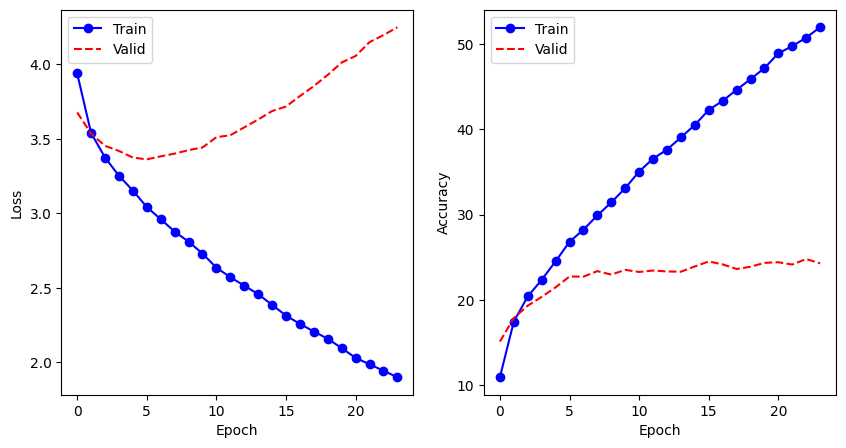

In [13]:

import matplotlib.pyplot as plt
fig=plt.figure(1,figsize=(10,5))

plt.subplot(1, 2, 1)
plt.plot(historySynScaW['train_loss'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_loss'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(historySynScaW['train_acc'], 'bo-', label='Train')
plt.plot(historySynScaW['valid_acc'], 'r--', label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [14]:
from tabulate import tabulate
data = [['Loss', test_loss_min, test_loss_min_SynScaL, test_loss_min_SynScaW],
['Accuracy', test_acc_max, test_acc_max_SynScaL, test_acc_max_SynScaW],
]
print (tabulate(data, headers=["Type", "Normal", "SynScaL", "SynScaW"]))

Type        Normal    SynScaL    SynScaW
--------  --------  ---------  ---------
Loss       3.35332    3.35733    3.36241
Accuracy  24.51      24.62      24.79
